In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing import timeseries_dataset_from_array


In [2]:
# load the ED visits dataset that has been cleaned and preprocessed
df_event_log_dl = pd.read_csv('df_event_log_visits_for_ML.csv')

In [3]:
df_event_log_dl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300775 entries, 0 to 300774
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             300775 non-null  object 
 1   SEX                             300775 non-null  int64  
 2   VISIT_ID                        300775 non-null  object 
 3   VISIT_AGE                       300775 non-null  float64
 4   CTAS                            300775 non-null  float64
 5   Case_Duration_Hours             300775 non-null  float64
 6   Is_Deceased                     300775 non-null  int64  
 7   Died_Before_Visit               300775 non-null  int64  
 8   Died_During_Visit               300775 non-null  int64  
 9   Died_After_Visit                300775 non-null  int64  
 10  Distance_to_Hospital            300775 non-null  float64
 11  Is_NL_Holiday                   300775 non-null  bool   
 12  Day_of_Week     

## Case Features:
Case features are attributes that are the same across all events within a single case (visit). 

In this case:

SID - Patient or session identifier (will be omitted for modeling as it doesn't add predictive value).

SEX - remains constant per case.

VISIT_ID - Case identifier - identifies the specific visit; constant for all events within that visit.

VISIT_AGE - Age of the patient, constant for the visit.

Is_Deceased - case attribute.

Distance_to_Hospital - constant for a given visit.

Is_NL_Holiday - constant for the visit.

Day_of_Week - constant for the visit.

Is_Weekend - constant for the visit.

Visit_Frequency - case-level feature.

Prior_LWBS - case-level feature.

Facility_IDs - case-level features.

Case_Duration_Hours - Duration of the case or visit, case-level feature.

TOTAL_PRECIPITATION - case-level features.

Imaging_Done - Whether imaging was done; specific to a case. 

Labs_Done - Whether lab tests were done; specific to a case. 

TIME_OF_THE_DAY_Ordinal - time of the day at the arrival of the patient, case-level feature.

Visit_Season_Ordinal - Season of the visit, specific to a case. 

## Event Features:
Event features are those that can vary from one event to another within the same visit:

CTAS - Triage score which can change if re-triaged during a visit.

ED_Business_Hourly - How busy the ED was, potentially varying hourly.

Activity_Encoded - varies by activity occurring during the visit. 

Is_LWBS - Indicates if the patient left without being seen, which is 
an outcome or event-specific feature.

Activity_Duration - Duration of specific activities within a visit.

Disposition_Frequency - Frequency of specific dispositions within the case, which could potentially vary as events unfold.

In [4]:
# Dropping the 'SID' column from the DataFrame
df_event_log_dl = df_event_log_dl.drop('SID', axis=1)

df_event_log_dl.head()

,SEX,VISIT_ID,VISIT_AGE,CTAS,Case_Duration_Hours,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Distance_to_Hospital,...,Activity_Assessment,Activity_Making admit decision,Activity_Patient departed,Activity_Patient discharge,Activity_Providing service,Activity_Triage,TIME_OF_THE_DAY_Ordinal,Visit_Season_Ordinal,Activity_Duration,Disposition_Frequency
0,1,VISIT2354278,26.166667,3.0,1.366667,0,0,0,0,55.947701,...,False,False,False,False,False,True,2.0,1.0,0.000000,1.0
1,1,VISIT2354278,26.166667,3.0,1.366667,0,0,0,0,55.947701,...,False,False,False,False,True,False,2.0,1.0,0.016667,1.0
2,1,VISIT2354278,26.166667,3.0,1.366667,0,0,0,0,55.947701,...,False,False,True,False,False,False,2.0,1.0,1.350000,1.0
3,1,VISIT2233914,22.000000,4.0,3.166667,0,0,0,0,243.167901,...,False,False,False,False,False,True,1.0,1.0,0.000000,1.0
4,1,VISIT2233914,22.000000,4.0,3.166667,0,0,0,0,243.167901,...,False,False,False,False,True,False,1.0,1.0,0.183333,1.0


In [5]:
# Sort by VISIT_ID before grouping
df_event_log_dl_sorted = df_event_log_dl.sort_values(by='VISIT_ID')
grouped = df_event_log_dl_sorted.groupby('VISIT_ID')

# Display the first few entries from each group
grouped.head()


,SEX,VISIT_ID,VISIT_AGE,CTAS,Case_Duration_Hours,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Distance_to_Hospital,...,Activity_Assessment,Activity_Making admit decision,Activity_Patient departed,Activity_Patient discharge,Activity_Providing service,Activity_Triage,TIME_OF_THE_DAY_Ordinal,Visit_Season_Ordinal,Activity_Duration,Disposition_Frequency
35374,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,False,False,False,False,False,True,0.0,1.0,0.000000,0.714286
35375,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,False,False,False,False,True,False,0.0,1.0,0.033333,0.714286
35376,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,True,False,False,False,False,False,0.0,1.0,0.100000,0.714286
35377,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,False,False,True,False,False,False,0.0,1.0,0.416667,0.714286
213202,0,VISIT2208404,23.166667,4.0,5.333333,0,0,0,0,0.429780,...,True,False,False,False,False,False,0.0,1.0,4.766667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258788,1,VISIT2377969,33.750000,4.0,2.750000,0,0,0,0,3.093499,...,False,False,False,False,False,True,2.0,1.0,0.000000,0.272727
148222,1,VISIT2377970,62.083333,3.0,8.233333,0,0,0,0,4.910799,...,False,False,False,False,True,False,2.0,1.0,0.116667,1.000000
148221,1,VISIT2377970,62.083333,3.0,8.233333,0,0,0,0,4.910799,...,False,False,False,False,False,True,2.0,1.0,0.000000,1.000000
148224,1,VISIT2377970,62.083333,3.0,8.233333,0,0,0,0,4.910799,...,False,False,True,False,False,False,2.0,1.0,0.150000,1.000000


In [6]:

sequences = []
sequence_length = 7  

import numpy as np

# Assume sequences is already defined as empty list
sequences = []
sequence_length = 7

for _, group in grouped:
    # Drop 'VISIT_ID' from the group, then convert to float
    group_features = group.drop(['Is_LWBS', 'VISIT_ID'], axis=1).astype(float)
    group_labels = group['Is_LWBS']
    
    # Padding if necessary
    num_missing = sequence_length - len(group)
    if num_missing > 0:
        # Padding features with zeros
        padding = np.zeros((num_missing, group_features.shape[1]))
        group_features = np.vstack((group_features, padding))
        # Padding labels with a neutral value or repeating the last known value
        padded_labels = np.pad(group_labels, (0, num_missing), 'edge')
    elif num_missing < 0:
        group_features = group_features.iloc[:sequence_length]
        group_labels = group_labels.iloc[:sequence_length]



    # Add to sequences
    sequences.append((group_features, group_labels.iloc[-1]))

# Convert to array for further processing
uniform_sequences = np.array([np.array(feature) for feature, label in sequences], dtype=object)
labels = np.array([label for feature, label in sequences])




In [7]:
uniform_sequences[0]

array([[1.0, 62.75, 3.0, 0.55, 0.0, 0.0, 0.0, 0.0, 22.233700149895167,
        0.0, 4.0, 0.0, 4.0, 0.0, 11.0, 1.0, 0.0, 64.0, 85.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,
        0.7142857142857143],
       [1.0, 62.75, 3.0, 0.55, 0.0, 0.0, 0.0, 0.0, 22.233700149895167,
        0.0, 4.0, 0.0, 4.0, 0.0, 11.0, 1.0, 0.0, 64.0, 85.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,
        0.0333333333333333, 0.7142857142857143],
       [1.0, 62.75, 3.0, 0.55, 0.0, 0.0, 0.0, 0.0, 22.233700149895167,
        0.0, 4.0, 0.0, 4.0, 0.0, 11.0, 1.0, 0.0, 64.0, 85.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.1,
        0.7142857142857143],
       [1.0, 62.75, 3.0, 0.55, 0.0, 0.0, 0.0, 0.0, 22.233700149895167,
        0.0, 4.0, 0.0, 4.0, 0.0, 11.0, 1.0, 0.0, 64.0, 85.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,
        0.4166666666666667, 0.7142857142857

In [8]:
# Calculate the indices for training, validation, and testing splits
train_idx = int(.6 * len(sequences))
val_idx = int(.8 * len(sequences))

# Splitting sequences and labels
train_sequences = sequences[:train_idx]
val_sequences = sequences[train_idx:val_idx]
test_sequences = sequences[val_idx:]

# Extracting features and labels from sequences
train_features = np.array([seq[0] for seq in train_sequences])
val_features = np.array([seq[0] for seq in val_sequences])
test_features = np.array([seq[0] for seq in test_sequences])

train_labels = np.array([seq[1] for seq in train_sequences])
val_labels = np.array([seq[1] for seq in val_sequences])
test_labels = np.array([seq[1] for seq in test_sequences])


In [9]:
train_features[0]


array([[1.00000000e+00, 6.27500000e+01, 3.00000000e+00, 5.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.22337001e+01, 0.00000000e+00, 4.00000000e+00, 0.00000000e+00,
        4.00000000e+00, 0.00000000e+00, 1.10000000e+01, 1.00000000e+00,
        0.00000000e+00, 6.40000000e+01, 8.50000000e+01, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 7.14285714e-01],
       [1.00000000e+00, 6.27500000e+01, 3.00000000e+00, 5.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.22337001e+01, 0.00000000e+00, 4.00000000e+00, 0.00000000e+00,
        4.00000000e+00, 0.00000000e+00, 1.10000000e+01, 1.00000000e+00,
        0.00000000e+00, 6.40000000e+01, 8.50000000e+01, 0.00000000e+00,
       

In [11]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(32)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(sequence_length, train_features.shape[2]), activation='relu'),  # Ensure input shape is correctly set
    Dense(1, activation='sigmoid')
])




In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
1460/1460 [==============================] - 16s 8ms/step - loss: 0.1825 - accuracy: 0.9309 - val_loss: 0.1494 - val_accuracy: 0.9028
Epoch 2/10
1460/1460 [==============================] - 11s 8ms/step - loss: 0.1251 - accuracy: 0.9464 - val_loss: 0.1044 - val_accuracy: 0.9591
Epoch 3/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0502 - accuracy: 0.9844 - val_loss: 0.0592 - val_accuracy: 0.9835
Epoch 4/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0409 - accuracy: 0.9903 - val_loss: 0.0621 - val_accuracy: 0.9866
Epoch 5/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0531 - accuracy: 0.9896 - val_loss: 0.0463 - val_accuracy: 0.9889
Epoch 6/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0341 - accuracy: 0.9907 - val_loss: 0.0831 - val_accuracy: 0.9796
Epoch 7/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0382 - accuracy: 0.9893 - val_loss: 0.0517 - val_ac

487/487 [==============================] - 2s 4ms/step
Confusion Matrix:
 [[13286   196]
 [   32  2058]]


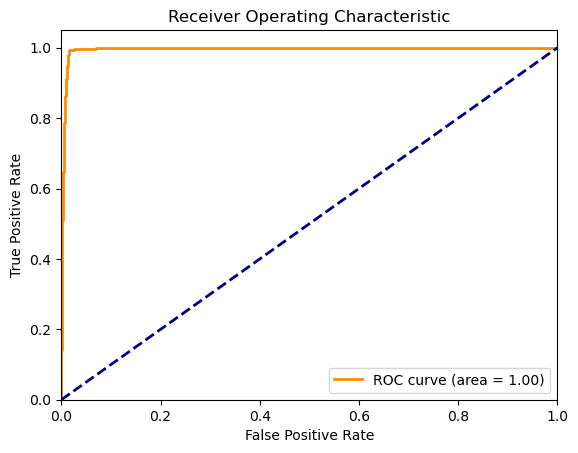

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate predictions
y_pred = model.predict(test_dataset).ravel()  # Flatten the predictions

# Converting probabilities to binary output based on a threshold
y_pred_bin = (y_pred > 0.5).astype('int')

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_bin)
print("Confusion Matrix:\n", cm)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


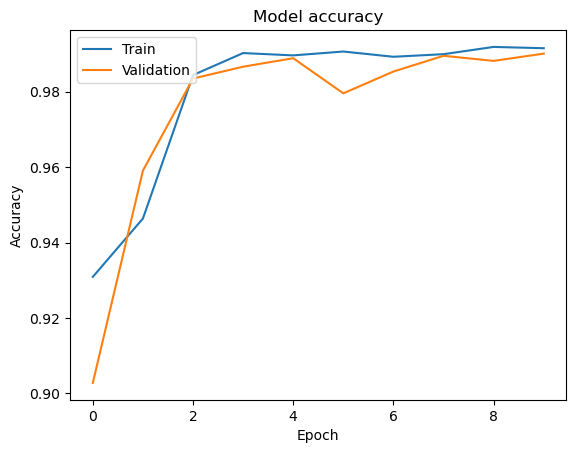

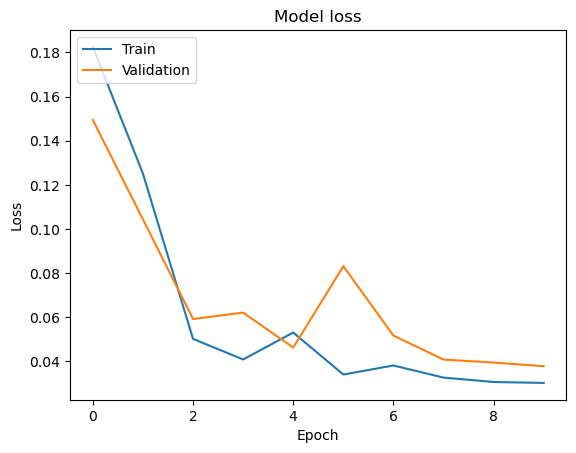

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


487/487 [==============================] - 2s 4ms/step - loss: 0.0472 - accuracy: 0.9854
Test Loss: 0.047177840024232864
Test Accuracy: 0.9853583574295044


In [20]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Assuming you have a complete dataset of features and labels
features = np.array([seq[0] for seq in sequences])  # Your feature sequences
labels = np.array([seq[1] for seq in sequences])    # Corresponding labels

# Define the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# This will be used to store scores or losses for each fold
fold_results = []


In [22]:
for train_index, test_index in tscv.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create a new instance of the model (to reset weights)
    model = Sequential([
        LSTM(50, input_shape=(sequence_length, X_train.shape[2]), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

   


In [24]:
 # Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

   

Epoch 1/10
2028/2028 [==============================] - 20s 8ms/step - loss: 0.2067 - accuracy: 0.9306 - val_loss: 0.1253 - val_accuracy: 0.9508
Epoch 2/10
2028/2028 [==============================] - 16s 8ms/step - loss: 0.0671 - accuracy: 0.9774 - val_loss: 0.0554 - val_accuracy: 0.9846
Epoch 3/10
2028/2028 [==============================] - 17s 8ms/step - loss: 0.0444 - accuracy: 0.9883 - val_loss: 0.0451 - val_accuracy: 0.9856
Epoch 4/10
2028/2028 [==============================] - 17s 8ms/step - loss: 0.0382 - accuracy: 0.9891 - val_loss: 0.0505 - val_accuracy: 0.9861
Epoch 5/10
2028/2028 [==============================] - 16s 8ms/step - loss: 0.0333 - accuracy: 0.9905 - val_loss: 0.0512 - val_accuracy: 0.9860
Epoch 6/10
2028/2028 [==============================] - 16s 8ms/step - loss: 0.0372 - accuracy: 0.9898 - val_loss: 0.0514 - val_accuracy: 0.9851
Epoch 7/10
2028/2028 [==============================] - 17s 8ms/step - loss: 0.0478 - accuracy: 0.9890 - val_loss: 0.0539 - val_ac

In [26]:
 # Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
fold_results.append(scores)




In [27]:
# After all folds are completed, you can calculate the average performance
average_performance = np.mean(fold_results, axis=0)
print(f"Average Performance across folds: {average_performance}")

Average Performance across folds: [0.04412176 0.98404747]
